In [1]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


# Combining data

We are going to combine data from the Novartis, NCATS, Carbon-Mangels and Veith datasets to try and come up with a set of compounds to test

## Novartis

Novartis have both a real world dataset and some public compounds they have labelled with an in-house developed model (surrogates) do we want to include both?

In [2]:
novartis_combined = pd.read_csv("processed/novartis_2024_combined.csv")

In [3]:
novartis_combined.head()

,SMILES,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6,Source,CANONICAL_SMILES,INCHIKEY,split,data_type,kobs,common_name,dataset,activity_class,action_type
0,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC.Cl.Cl,-2.131,4.957,4.733,4.823,ChEMBL,CCCCc1nc2cc(/C=C/C(O)=NO)ccc2n1CCN(CC)CC,JHDKZFFAIZKUCU-ZRDIBKRKSA-N,train,surrogate,NaN,NaN,novartis_2024,negative,inhibitor
1,CCCCc1ccc(N/C=N/O)cc1,-2.300,4.597,4.857,4.716,ChEMBL,CCCCc1ccc(NC=NO)cc1,BQPCBRFOSWMALO-UHFFFAOYSA-N,train,surrogate,NaN,NaN,novartis_2024,negative,inhibitor
2,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,-1.940,4.740,4.686,4.883,ChEMBL,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,HJEPFPDXSFKWQH-IBGZPJMESA-N,train,surrogate,NaN,NaN,novartis_2024,weak_positive,inhibitor
3,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,-2.151,4.453,4.543,4.525,ChEMBL,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,OBNKFIQHMAHNEE-UHFFFAOYSA-N,train,surrogate,NaN,NaN,novartis_2024,negative,inhibitor
4,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,-2.283,4.372,4.432,4.463,ChEMBL,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,ABAOSSRHMRVEJF-UHFFFAOYSA-N,train,surrogate,NaN,NaN,novartis_2024,negative,inhibitor


In [4]:
novartis_combined.data_type.value_counts()

data_type
surrogate    16370
assay          368
Name: count, dtype: int64

<Axes: xlabel='pIC50_CYP3A4', ylabel='Count'>

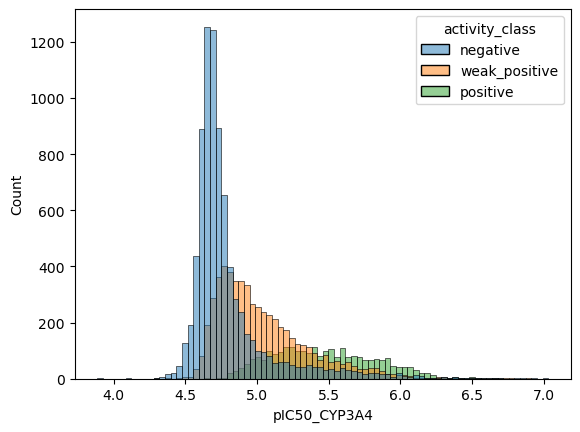

In [5]:
# examine the distirbution of pIC50s over the activity binnings, these are generated with MODEL ie surrogate dataset
sns.histplot(data=novartis_combined, x="pIC50_CYP3A4", hue="activity_class")


(-4.0, 0.0)

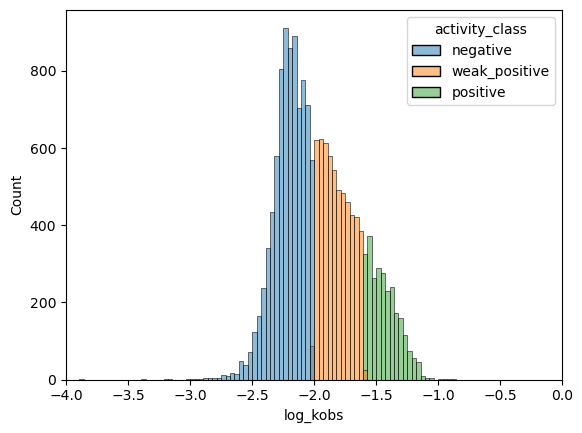

In [6]:
# examine binning by activity class over full dataset
fig, ax = plt.subplots()
sns.histplot(data=novartis_combined, x="log_kobs", hue="activity_class", ax=ax)
ax.set_xlim(-4, 0)

In [7]:
# examine only the real data from public compounds, these were actually assayed

novartis_real = novartis_combined.query("data_type == 'assay'")

<Axes: xlabel='activity_class', ylabel='count'>

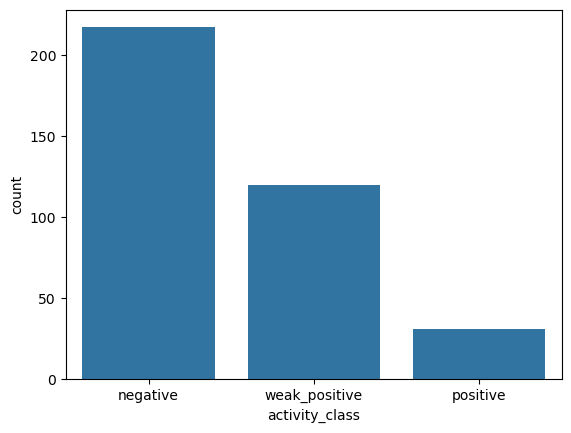

In [8]:
sns.countplot(data=novartis_real, x="activity_class")

(-4.0, 0.0)

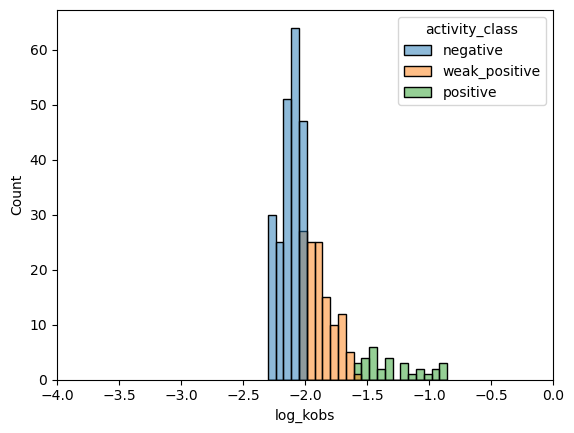

In [9]:
fig, ax = plt.subplots()
sns.histplot(data=novartis_real, x="log_kobs", hue="activity_class")
ax.set_xlim(-4, 0)

# Decision?

Lets start with including the surrogate dataset as there are only 50 points in positive class of "real" dataset, we will see if we can cross validate

In [10]:
# ok lets grab actives

novartis_actives = novartis_combined.query("activity_class == 'positive'")
# add a column we will use consistently
novartis_actives["active"] = True



/tmp/ipykernel_51925/815307204.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novartis_actives["active"] = True


In [11]:
# drop the rest 
keep_cols_all = ["CANONICAL_SMILES", "INCHIKEY", "active", "dataset", "data_type", "common_name", "action_type"]
novartis_actives = novartis_actives[keep_cols_all]

In [12]:
novartis_actives

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type
5,O=[N+]([O-])c1cccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F...,FOTDWYFVTJDSLW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
8,COc1ccc(C(O)c2c3cc(OC)cc(C)c3nc3[nH]nc(C)c23)cc1,NJVOBGWGMQUPTG-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
9,NC(C(=O)N1CCC(Nc2ccc3[nH]ncc3c2)CC1)c1ccccc1,AGVLKBKXJWTFQT-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
12,Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4CC5CCC4C...,RMVSZBRIILAXIH-WUXOVTSDSA-N,True,novartis_2024,surrogate,NaN,inhibitor
19,O=[N+]([O-])c1ccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F)...,RYGJKZCQNUAGKW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
...,...,...,...,...,...,...,...
16697,CCC1C(C)=NN=C(c2ccc(OC)c(OC)c2)c2cc(OC)c(OC)cc21,RUJBDQSFYCKFAA-UHFFFAOYSA-N,True,novartis_2024,assay,Tofisopam,inhibitor
16721,Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(Cc3sc(=O)[nH...,BJWJSFCBOIUATF-UHFFFAOYSA-N,True,novartis_2024,assay,Troglitazone,inhibitor
16722,CO[C@H]1C[C@H](O[C@@H]2C(C)C(=O)O[C@H](C)[C@H]...,LQCLVBQBTUVCEQ-WXGPWXIXSA-N,True,novartis_2024,assay,Troleandomycin,inhibitor
16727,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,SGTNSNPWRIOYBX-UHFFFAOYSA-N,True,novartis_2024,assay,Verapamil,inhibitor


# NCATS
This is a pretty messy AID, but we will take what we can get, was also classified prior to pubchem upload




In [13]:
ncats = pd.read_csv("processed/ncats_adme_aid1645841.csv")

In [14]:
ncats.head()

,CANONICAL_SMILES,INCHIKEY,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CID,dataset,data_type,common_name,action_type
0,Cc1ccc2c(c1)c1c(n2CCc2ccc(C)nc2)CCN(C)C1,JNODQFNWMXFMEV-UHFFFAOYSA-N,Active,197033,ncats_adme_aid1645841,assay,NaN,inhibitor
1,O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12,YXOLAZRVSSWPPT-UHFFFAOYSA-N,Inactive,5281670,ncats_adme_aid1645841,assay,NaN,inhibitor
2,Cc1ccc(C(=O)NC2C(=O)NC(C(C)C)C(=O)N3CCCC3C(=O)...,GQBHKSFHNFMVES-TYWDLNKHSA-N,Inconclusive,6604832,ncats_adme_aid1645841,assay,NaN,inhibitor
3,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,KZNIFHPLKGYRTM-UHFFFAOYSA-N,Active,5280443,ncats_adme_aid1645841,assay,NaN,inhibitor
4,NC(Cc1ccc(O)c(O)c1)C(=O)O,WTDRDQBEARUVNC-UHFFFAOYSA-N,Active,836,ncats_adme_aid1645841,assay,NaN,inhibitor


<Axes: xlabel='PUBCHEM_ACTIVITY_OUTCOME', ylabel='count'>

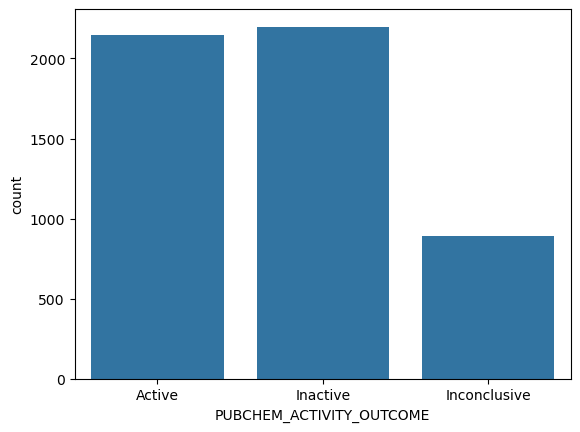

In [15]:
sns.countplot(data=ncats, x="PUBCHEM_ACTIVITY_OUTCOME")


In [16]:
ncats_actives = ncats.query("PUBCHEM_ACTIVITY_OUTCOME == 'Active'")
ncats_actives["active"] = True

/tmp/ipykernel_51925/667201052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncats_actives["active"] = True


In [17]:
ncats_actives.head()

,CANONICAL_SMILES,INCHIKEY,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CID,dataset,data_type,common_name,action_type,active
0,Cc1ccc2c(c1)c1c(n2CCc2ccc(C)nc2)CCN(C)C1,JNODQFNWMXFMEV-UHFFFAOYSA-N,Active,197033,ncats_adme_aid1645841,assay,NaN,inhibitor,True
3,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,KZNIFHPLKGYRTM-UHFFFAOYSA-N,Active,5280443,ncats_adme_aid1645841,assay,NaN,inhibitor,True
4,NC(Cc1ccc(O)c(O)c1)C(=O)O,WTDRDQBEARUVNC-UHFFFAOYSA-N,Active,836,ncats_adme_aid1645841,assay,NaN,inhibitor,True
6,CC1=NN=C(c2ccc(N)cc2)c2cc3c(cc2C1)OCO3,LFBZZHVSGAHQPP-UHFFFAOYSA-N,Active,3538,ncats_adme_aid1645841,assay,NaN,inhibitor,True
7,CC(=O)C1(O)C=C2C(=O)c3c(c(O)c4ccccc4c3O)C(=O)C...,SZWGDFGULWLMIP-UHFFFAOYSA-N,Active,3685,ncats_adme_aid1645841,assay,NaN,inhibitor,True


In [18]:
ncats_actives = ncats_actives[keep_cols_all]
ncats_actives

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type
0,Cc1ccc2c(c1)c1c(n2CCc2ccc(C)nc2)CCN(C)C1,JNODQFNWMXFMEV-UHFFFAOYSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
3,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,KZNIFHPLKGYRTM-UHFFFAOYSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
4,NC(Cc1ccc(O)c(O)c1)C(=O)O,WTDRDQBEARUVNC-UHFFFAOYSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
6,CC1=NN=C(c2ccc(N)cc2)c2cc3c(cc2C1)OCO3,LFBZZHVSGAHQPP-UHFFFAOYSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
7,CC(=O)C1(O)C=C2C(=O)c3c(c(O)c4ccccc4c3O)C(=O)C...,SZWGDFGULWLMIP-UHFFFAOYSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
...,...,...,...,...,...,...,...
5223,Cc1cc(N)c2ccccc2[n+]1CCCCCCCCCC[n+]1c(C)cc(N)c...,PCSWXVJAIHCTMO-UHFFFAOYSA-P,True,ncats_adme_aid1645841,assay,NaN,inhibitor
5227,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]...,CJBJHOAVZSMMDJ-HEXNFIEUSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
5228,O=C(Nc1cccc2c(=O)cc(-c3nn[nH]n3)oc12)c1ccc(OCC...,NBQKINXMPLXUET-UHFFFAOYSA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor
5232,CCCCCCCC/C=C\CCCCCCCC(=O)NCc1ccc(O)c(OC)c1,OPZKBPQVWDSATI-KHPPLWFESA-N,True,ncats_adme_aid1645841,assay,NaN,inhibitor


# Veith

Assay data from veith et al


In [19]:
veith = pd.read_csv("processed/veith_2009.csv")
veith.head()

,PubChemCID,SMILES,Active,CANONICAL_SMILES,INCHIKEY,dataset,data_type,common_name,action_type
0,6602638.0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,ULLDFBZUOXJYID-UHFFFAOYSA-N,veith_2009,assay,NaN,inhibitor
1,644510.0,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,VTLXYSNKFGEFDQ-UHFFFAOYSA-N,veith_2009,assay,NaN,inhibitor
2,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,GEUQHFHLRHDTPU-UHFFFAOYSA-N,veith_2009,assay,NaN,inhibitor
3,644890.0,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,JGYZDKDCKPRYSN-UHFFFAOYSA-N,veith_2009,assay,NaN,inhibitor
4,645063.0,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,SZEOGUBNOIXRLP-UHFFFAOYSA-N,veith_2009,assay,NaN,inhibitor


<Axes: xlabel='Active', ylabel='count'>

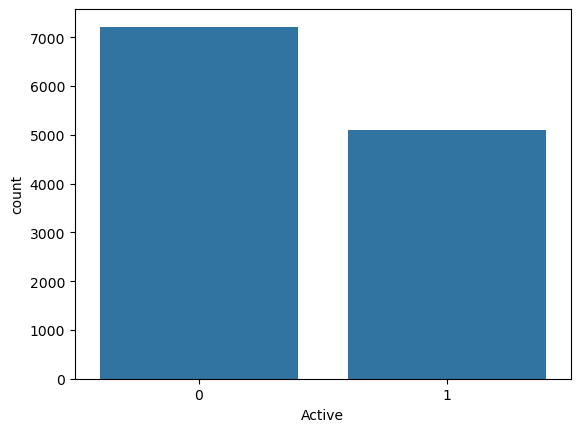

In [20]:
sns.countplot(data=veith, x="Active")


In [21]:
veith_actives = veith.query("Active == 1")
veith_actives["active"] = True
veith_actives = veith_actives[keep_cols_all]

/tmp/ipykernel_51925/1919675608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veith_actives["active"] = True


In [22]:
veith_actives

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type
1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,VTLXYSNKFGEFDQ-UHFFFAOYSA-N,True,veith_2009,assay,NaN,inhibitor
2,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,GEUQHFHLRHDTPU-UHFFFAOYSA-N,True,veith_2009,assay,NaN,inhibitor
3,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,JGYZDKDCKPRYSN-UHFFFAOYSA-N,True,veith_2009,assay,NaN,inhibitor
5,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,NFTSIGQBJYZZLX-UHFFFAOYSA-N,True,veith_2009,assay,NaN,inhibitor
10,CCN(CC)C(=O)CSc1nnc(-c2cc3ccccc3cc2O)n1CC,VVRVXVFZSWROHR-UHFFFAOYSA-N,True,veith_2009,assay,NaN,inhibitor
...,...,...,...,...,...,...,...
12290,CC[C@@H](c1ccccc1)n1c(=O)n2n(c1=O)[C@H]1[C@H](...,ZLCSKEDISVLOJH-RWKWVPCPSA-N,True,veith_2009,assay,NaN,inhibitor
12296,O=c1n(Cc2cc3c(cc2Cl)OCO3)c(=O)n2n1CC[C@H]1/C(=...,OFANGNFUSNKWLW-ICBRJBJWSA-N,True,veith_2009,assay,NaN,inhibitor
12297,CC(C)CO/N=C1/[C@H]2O[C@@H]2[C@@H](O)[C@H]2[C@H...,XQGYPVYSJBOIOQ-LXUUIWEGSA-N,True,veith_2009,assay,NaN,inhibitor
12299,O=c1n(Cc2cc3c(cc2Cl)OCO3)c(=O)n2n1CC[C@H]1/C(=...,DFKPBUZAUWTLJY-KVRHHBQGSA-N,True,veith_2009,assay,NaN,inhibitor


# Carbon-Mangels

Composite dataset from Carbon-Mangels

In [23]:
carbon_mangels = pd.read_csv("processed/carbon-mangels_2011.csv")
carbon_mangels.head()

,common_name,SMILES,Active,CANONICAL_SMILES,INCHIKEY,dataset,data_type,action_type
0,abacavir,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,0,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,MCGSCOLBFJQGHM-SCZZXKLOSA-N,carbon-mangels_2011,assay,substrate
1,abecarnil,COCc1c(C(=O)OC(C)C)ncc2[nH]c3ccc(OCc4ccccc4)cc...,0,COCc1c(C(=O)OC(C)C)ncc2[nH]c3ccc(OCc4ccccc4)cc...,RLFKILXOLJVUNF-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
2,abiraterone,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,0,C[C@]12CC[C@H](O)CC1=CC[C@@H]1[C@@H]2CC[C@]2(C...,GZOSMCIZMLWJML-VJLLXTKPSA-N,carbon-mangels_2011,assay,substrate
3,acebutolol,CCCC(=O)Nc1ccc(OC[C@@H](O)CNC(C)C)c(C(C)=O)c1,0,CCCC(=O)Nc1ccc(OC[C@@H](O)CNC(C)C)c(C(C)=O)c1,GOEMGAFJFRBGGG-HNNXBMFYSA-N,carbon-mangels_2011,assay,substrate
4,aceclofenac,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,0,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,MNIPYSSQXLZQLJ-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate


<Axes: xlabel='Active', ylabel='count'>

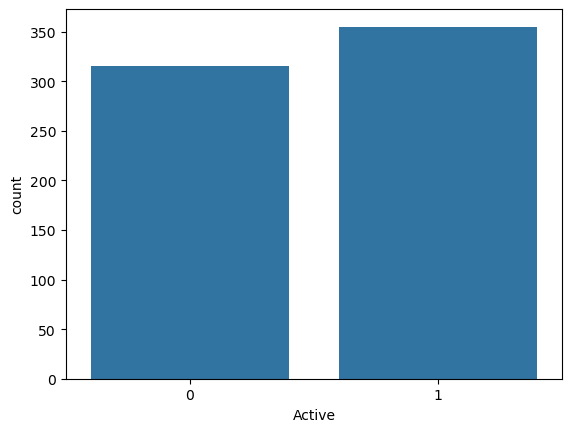

In [24]:
sns.countplot(data=carbon_mangels, x="Active")


In [25]:
carbon_mangels_actives = carbon_mangels.query("Active == 1")

In [26]:
carbon_mangels_actives

,common_name,SMILES,Active,CANONICAL_SMILES,INCHIKEY,dataset,data_type,action_type
5,acenocoumarol,CC(=O)C[C@@H](c1ccc([N+](=O)[O-])cc1)c1c(O)c2c...,1,CC(=O)C[C@@H](c1ccc([N+](=O)[O-])cc1)c1c(O)c2c...,VABCILAOYCMVPS-HNNXBMFYSA-N,carbon-mangels_2011,assay,substrate
7,acetaminophen,CC(=O)Nc1ccc(O)cc1,1,CC(=O)Nc1ccc(O)cc1,RZVAJINKPMORJF-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
11,adinazolam,CN(C)Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1)=NC2,1,CN(C)Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1)=NC2,GJSLOMWRLALDCT-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
13,albendazole,CCCSc1ccc2nc(NC(=O)OC)[nH]c2c1,1,CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1,HXHWSAZORRCQMX-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
15,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,1,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,IDBPHNDTYPBSNI-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
...,...,...,...,...,...,...,...,...
663,ziprasidone,O=C1Cc2cc(CCN3CCN(c4nsc5ccccc45)CC3)c(Cl)cc2N1,1,Oc1cc2cc(CCN3CCN(c4nsc5ccccc45)CC3)c(Cl)cc2[nH]1,CARRCRVKWDEWCD-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
665,zolpidem,Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1,1,Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
666,zonisamide,NS(=O)(=O)Cc1noc2ccccc12,1,NS(=O)(=O)Cc1noc2ccccc12,UBQNRHZMVUUOMG-UHFFFAOYSA-N,carbon-mangels_2011,assay,substrate
667,zopiclone,CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2...,1,CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2...,GBBSUAFBMRNDJC-INIZCTEOSA-N,carbon-mangels_2011,assay,substrate


In [27]:
carbon_mangels_actives["active"] = True
carbon_mangels_actives = carbon_mangels_actives[keep_cols_all]

/tmp/ipykernel_51925/225345057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_mangels_actives["active"] = True


In [28]:
carbon_mangels_actives

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type
5,CC(=O)C[C@@H](c1ccc([N+](=O)[O-])cc1)c1c(O)c2c...,VABCILAOYCMVPS-HNNXBMFYSA-N,True,carbon-mangels_2011,assay,acenocoumarol,substrate
7,CC(=O)Nc1ccc(O)cc1,RZVAJINKPMORJF-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,acetaminophen,substrate
11,CN(C)Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1)=NC2,GJSLOMWRLALDCT-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,adinazolam,substrate
13,CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1,HXHWSAZORRCQMX-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,albendazole,substrate
15,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,IDBPHNDTYPBSNI-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,alfentanil,substrate
...,...,...,...,...,...,...,...
663,Oc1cc2cc(CCN3CCN(c4nsc5ccccc45)CC3)c(Cl)cc2[nH]1,CARRCRVKWDEWCD-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,ziprasidone,substrate
665,Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,zolpidem,substrate
666,NS(=O)(=O)Cc1noc2ccccc12,UBQNRHZMVUUOMG-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,zonisamide,substrate
667,CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2...,GBBSUAFBMRNDJC-INIZCTEOSA-N,True,carbon-mangels_2011,assay,zopiclone,substrate


# Chembl

The chembl data is an aggregation for CYP3A4  P08684

Some postprocessing steps have been applied to select high quality actives from the range of assays available, defs not the only way to do this. 




* Select assays with IC50, AC50, pIC50, XC50, EC50, Ki or potency endpoints
* Select assays in nM
* Select assays with >=  N molecules (10)
* Select compounds with mean pChembl > 5 accross all assays
* Select compounds that appear in >= L of assays



In [29]:
chembl_actives = pd.read_csv("processed/chembl_active_selected.csv")
chembl_actives.head()

,CANONICAL_SMILES,INCHIKEY,pChEMBL mean,pChEMBL std,common_name,appears_in_N_ChEMBL_assays,action_type,dataset,active
0,CC(=O)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(c4ccc(Cl)c...,XMAYWYJOQHXEEK-UHFFFAOYSA-N,7.013500,0.618796,KETOCONAZOLE,21,NaN,ChEMBL_curated,True
1,CCC1C(=O)OC[C@H]1Cc1cncn1C,QCHFTSOMWOSFHM-HNHGDDPOSA-N,5.052941,0.285302,SALAGEN,17,NaN,ChEMBL_curated,True
2,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,VNFPBHJOKIVQEB-UHFFFAOYSA-N,7.237692,0.358798,CLOTRIMAZOLE,14,NaN,ChEMBL_curated,True
3,CNCCCC12CCC(c3ccccc31)c1ccccc12,QSLMDECMDJKHMQ-UHFFFAOYSA-N,5.473846,0.281470,MAPROTILINE HYDROCHLORIDE,13,NaN,ChEMBL_curated,True
4,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,BYBLEWFAAKGYCD-UHFFFAOYSA-N,6.060000,0.608590,MICONAZOLE NITRATE,12,NaN,ChEMBL_curated,True


# Combine everything


## NOTE

common name being blank is not that these compounds do not have a common name, but that they need to be pulled from pubchem

In [30]:
combined_literature = pd.concat([novartis_actives, ncats_actives, veith_actives, carbon_mangels_actives])
combined_literature

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type
5,O=[N+]([O-])c1cccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F...,FOTDWYFVTJDSLW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
8,COc1ccc(C(O)c2c3cc(OC)cc(C)c3nc3[nH]nc(C)c23)cc1,NJVOBGWGMQUPTG-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
9,NC(C(=O)N1CCC(Nc2ccc3[nH]ncc3c2)CC1)c1ccccc1,AGVLKBKXJWTFQT-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
12,Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4CC5CCC4C...,RMVSZBRIILAXIH-WUXOVTSDSA-N,True,novartis_2024,surrogate,NaN,inhibitor
19,O=[N+]([O-])c1ccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F)...,RYGJKZCQNUAGKW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor
...,...,...,...,...,...,...,...
663,Oc1cc2cc(CCN3CCN(c4nsc5ccccc45)CC3)c(Cl)cc2[nH]1,CARRCRVKWDEWCD-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,ziprasidone,substrate
665,Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,zolpidem,substrate
666,NS(=O)(=O)Cc1noc2ccccc12,UBQNRHZMVUUOMG-UHFFFAOYSA-N,True,carbon-mangels_2011,assay,zonisamide,substrate
667,CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2...,GBBSUAFBMRNDJC-INIZCTEOSA-N,True,carbon-mangels_2011,assay,zopiclone,substrate


In [31]:
combined_literature.INCHIKEY.duplicated().sum()  # close same result with SMILES

np.int64(971)

In [32]:
combined_literature.dropna(subset="INCHIKEY", inplace=True)

In [33]:
combined_literature_chembl = pd.concat([combined_literature, chembl_actives])

In [34]:
combined_literature_chembl

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type,pChEMBL mean,pChEMBL std,appears_in_N_ChEMBL_assays
5,O=[N+]([O-])c1cccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F...,FOTDWYFVTJDSLW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
8,COc1ccc(C(O)c2c3cc(OC)cc(C)c3nc3[nH]nc(C)c23)cc1,NJVOBGWGMQUPTG-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
9,NC(C(=O)N1CCC(Nc2ccc3[nH]ncc3c2)CC1)c1ccccc1,AGVLKBKXJWTFQT-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
12,Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4CC5CCC4C...,RMVSZBRIILAXIH-WUXOVTSDSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
19,O=[N+]([O-])c1ccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F)...,RYGJKZCQNUAGKW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2691,CO[C@H]1COC(=O)C(C)NC(=O)C/C=C\[C@@H](C)[C@@H]...,YMMZNHJLDTYKIO-IRNQRVLXSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.4,0.0,3.0
2692,c1cc(NC2CC2)nc(-c2ccoc2)n1,ITBQVUHQAISPBQ-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.3,0.0,3.0
2693,O=c1cc(O)cc(C=Cc2ccc(O)c(O)c2)o1,SGJNQVTUYXCBKH-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.5,0.0,3.0
2694,Fc1ccc(Nc2ncncc2-c2ccccc2C(F)(F)F)cc1,KGLWGKSRHOVICM-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,6.4,0.0,3.0


In [35]:
combined_literature_chembl.dataset.value_counts()

dataset
veith_2009               5110
ChEMBL_curated           2696
novartis_2024            2639
ncats_adme_aid1645841    2146
carbon-mangels_2011       355
Name: count, dtype: int64

In [36]:
combined_literature_chembl.INCHIKEY.duplicated().sum()

np.int64(2880)

In [37]:
combined_literature_chembl.INCHIKEY.isna().sum()

np.int64(0)

In [38]:
combined_literature_chembl

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type,pChEMBL mean,pChEMBL std,appears_in_N_ChEMBL_assays
5,O=[N+]([O-])c1cccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F...,FOTDWYFVTJDSLW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
8,COc1ccc(C(O)c2c3cc(OC)cc(C)c3nc3[nH]nc(C)c23)cc1,NJVOBGWGMQUPTG-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
9,NC(C(=O)N1CCC(Nc2ccc3[nH]ncc3c2)CC1)c1ccccc1,AGVLKBKXJWTFQT-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
12,Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4CC5CCC4C...,RMVSZBRIILAXIH-WUXOVTSDSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
19,O=[N+]([O-])c1ccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F)...,RYGJKZCQNUAGKW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2691,CO[C@H]1COC(=O)C(C)NC(=O)C/C=C\[C@@H](C)[C@@H]...,YMMZNHJLDTYKIO-IRNQRVLXSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.4,0.0,3.0
2692,c1cc(NC2CC2)nc(-c2ccoc2)n1,ITBQVUHQAISPBQ-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.3,0.0,3.0
2693,O=c1cc(O)cc(C=Cc2ccc(O)c(O)c2)o1,SGJNQVTUYXCBKH-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.5,0.0,3.0
2694,Fc1ccc(Nc2ncncc2-c2ccccc2C(F)(F)F)cc1,KGLWGKSRHOVICM-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,6.4,0.0,3.0


In [39]:
appears = combined_literature_chembl.groupby("INCHIKEY")["dataset"].nunique().reset_index(name="appears_in_N_datasets")
appears.set_index("INCHIKEY")

,appears_in_N_datasets
INCHIKEY,
AABFWJDLCCDJJN-UHFFFAOYSA-N,1
AABYLPRACHMDSN-BIWBPYCESA-N,3
AABYLPRACHMDSN-REETXPBOSA-N,3
AAEXTICMMYDGTO-UHFFFAOYSA-N,1
AAGIFVFWIBEXDH-UHFFFAOYSA-N,2
...,...
ZZQYLRUTULGFDB-OHJDGCPNSA-N,2
ZZUUFZGULQUYPH-UHFFFAOYSA-N,1
ZZVAYOCXKRUKNH-UHFFFAOYSA-N,3


In [40]:
appears.isna().sum()

INCHIKEY                 0
appears_in_N_datasets    0
dtype: int64

<Axes: xlabel='appears_in_N_datasets', ylabel='count'>

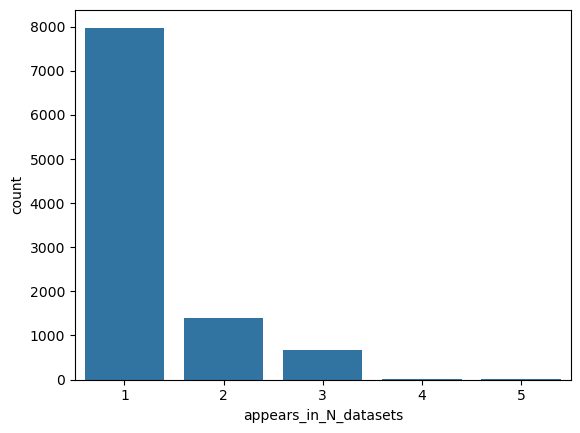

In [41]:
sns.countplot(data=appears, x="appears_in_N_datasets")

In [42]:
combined_literature_chembl_w_counts = combined_literature_chembl.merge(appears, on="INCHIKEY")
combined_literature_chembl_w_counts

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type,pChEMBL mean,pChEMBL std,appears_in_N_ChEMBL_assays,appears_in_N_datasets
0,O=[N+]([O-])c1cccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F...,FOTDWYFVTJDSLW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1
1,COc1ccc(C(O)c2c3cc(OC)cc(C)c3nc3[nH]nc(C)c23)cc1,NJVOBGWGMQUPTG-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1
2,NC(C(=O)N1CCC(Nc2ccc3[nH]ncc3c2)CC1)c1ccccc1,AGVLKBKXJWTFQT-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1
3,Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4CC5CCC4C...,RMVSZBRIILAXIH-WUXOVTSDSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1
4,O=[N+]([O-])c1ccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F)...,RYGJKZCQNUAGKW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
12941,CO[C@H]1COC(=O)C(C)NC(=O)C/C=C\[C@@H](C)[C@@H]...,YMMZNHJLDTYKIO-IRNQRVLXSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.4,0.0,3.0,2
12942,c1cc(NC2CC2)nc(-c2ccoc2)n1,ITBQVUHQAISPBQ-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.3,0.0,3.0,2
12943,O=c1cc(O)cc(C=Cc2ccc(O)c(O)c2)o1,SGJNQVTUYXCBKH-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.5,0.0,3.0,1
12944,Fc1ccc(Nc2ncncc2-c2ccccc2C(F)(F)F)cc1,KGLWGKSRHOVICM-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,6.4,0.0,3.0,2


In [43]:
df_dummies = pd.get_dummies(combined_literature_chembl_w_counts['dataset'], prefix='dataset').join(combined_literature_chembl_w_counts["INCHIKEY"])
df_dummies

,dataset_ChEMBL_curated,dataset_carbon-mangels_2011,dataset_ncats_adme_aid1645841,dataset_novartis_2024,dataset_veith_2009,INCHIKEY
0,False,False,False,True,False,FOTDWYFVTJDSLW-UHFFFAOYSA-N
1,False,False,False,True,False,NJVOBGWGMQUPTG-UHFFFAOYSA-N
2,False,False,False,True,False,AGVLKBKXJWTFQT-UHFFFAOYSA-N
3,False,False,False,True,False,RMVSZBRIILAXIH-WUXOVTSDSA-N
4,False,False,False,True,False,RYGJKZCQNUAGKW-UHFFFAOYSA-N
...,...,...,...,...,...,...
12941,True,False,False,False,False,YMMZNHJLDTYKIO-IRNQRVLXSA-N
12942,True,False,False,False,False,ITBQVUHQAISPBQ-UHFFFAOYSA-N
12943,True,False,False,False,False,SGJNQVTUYXCBKH-UHFFFAOYSA-N
12944,True,False,False,False,False,KGLWGKSRHOVICM-UHFFFAOYSA-N


In [44]:
df_result = df_dummies.groupby('INCHIKEY').max().reset_index()
df_result = df_result.set_index("INCHIKEY")

In [45]:
# cat_dataname = combined_literature_chembl.groupby("INCHIKEY")["dataset"].apply(lambda x: "_+_".join(x)).reset_index(name="dataset_comb").set_index("INCHIKEY")
# cat_dataname

In [46]:
combined_literature_chembl_w_counts = combined_literature_chembl_w_counts.merge(df_result, on="INCHIKEY")
combined_literature_chembl_w_counts

,CANONICAL_SMILES,INCHIKEY,active,dataset,data_type,common_name,action_type,pChEMBL mean,pChEMBL std,appears_in_N_ChEMBL_assays,appears_in_N_datasets,dataset_ChEMBL_curated,dataset_carbon-mangels_2011,dataset_ncats_adme_aid1645841,dataset_novartis_2024,dataset_veith_2009
0,O=[N+]([O-])c1cccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F...,FOTDWYFVTJDSLW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1,False,False,False,True,False
1,COc1ccc(C(O)c2c3cc(OC)cc(C)c3nc3[nH]nc(C)c23)cc1,NJVOBGWGMQUPTG-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1,False,False,False,True,False
2,NC(C(=O)N1CCC(Nc2ccc3[nH]ncc3c2)CC1)c1ccccc1,AGVLKBKXJWTFQT-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1,False,False,False,True,False
3,Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4CC5CCC4C...,RMVSZBRIILAXIH-WUXOVTSDSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1,False,False,False,True,False
4,O=[N+]([O-])c1ccc2[nH]c3c(N4CCN(CCc5ccc(F)c(F)...,RYGJKZCQNUAGKW-UHFFFAOYSA-N,True,novartis_2024,surrogate,NaN,inhibitor,NaN,NaN,NaN,1,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941,CO[C@H]1COC(=O)C(C)NC(=O)C/C=C\[C@@H](C)[C@@H]...,YMMZNHJLDTYKIO-IRNQRVLXSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.4,0.0,3.0,2,True,False,False,False,True
12942,c1cc(NC2CC2)nc(-c2ccoc2)n1,ITBQVUHQAISPBQ-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.3,0.0,3.0,2,True,False,False,False,True
12943,O=c1cc(O)cc(C=Cc2ccc(O)c(O)c2)o1,SGJNQVTUYXCBKH-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,5.5,0.0,3.0,1,True,False,False,False,False
12944,Fc1ccc(Nc2ncncc2-c2ccccc2C(F)(F)F)cc1,KGLWGKSRHOVICM-UHFFFAOYSA-N,True,ChEMBL_curated,NaN,NaN,NaN,6.4,0.0,3.0,2,True,False,False,False,True


In [56]:
combined_literature_chembl_w_counts.action_type.value_counts()

action_type
inhibitor    7111
substrate     260
Name: count, dtype: int64

In [47]:
combined_literature_chembl_w_counts.INCHIKEY.nunique()

10066

In [48]:
combined_literature_chembl_w_counts['common_name'].isna().sum()

np.int64(12306)

In [49]:
# we can just sort by appears_in_N_ChEMBL_assays to get all the chembl data at the top, then uniquify on INCHIKEY

combined_literature_chembl_w_counts.sort_values(["appears_in_N_ChEMBL_assays", "appears_in_N_datasets"], ascending=[False,False],  inplace=True)


In [50]:
# fill common name from gropupby 
combined_literature_chembl_w_counts['common_name'] = combined_literature_chembl_w_counts.groupby('INCHIKEY')['common_name'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/tmp/ipykernel_51925/1877288904.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_literature_chembl_w_counts['common_name'] = combined_literature_chembl_w_counts.groupby('INCHIKEY')['common_name'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/tmp/ipykernel_51925/1877288904.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_literature_chembl_w_counts['common_name'] = combined_literature_chembl_w_counts.groupby('INCHIKEY')['common_name'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [51]:
combined_literature_chembl_w_counts['common_name'].isna().sum()

np.int64(11979)

In [52]:
combined_literature_chembl_w_counts.drop(columns=["dataset","data_type"], inplace=True)

In [57]:
combined_literature_chembl_w_counts.head()

,CANONICAL_SMILES,INCHIKEY,active,common_name,action_type,pChEMBL mean,pChEMBL std,appears_in_N_ChEMBL_assays,appears_in_N_datasets,dataset_ChEMBL_curated,dataset_carbon-mangels_2011,dataset_ncats_adme_aid1645841,dataset_novartis_2024,dataset_veith_2009
10250,CC(=O)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(c4ccc(Cl)c...,XMAYWYJOQHXEEK-UHFFFAOYSA-N,True,KETOCONAZOLE,NaN,7.013500,0.618796,21.0,1,True,False,False,False,False
10251,CCC1C(=O)OC[C@H]1Cc1cncn1C,QCHFTSOMWOSFHM-HNHGDDPOSA-N,True,SALAGEN,NaN,5.052941,0.285302,17.0,1,True,False,False,False,False
10252,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,VNFPBHJOKIVQEB-UHFFFAOYSA-N,True,CLOTRIMAZOLE,NaN,7.237692,0.358798,14.0,3,True,True,True,False,False
10253,CNCCCC12CCC(c3ccccc31)c1ccccc12,QSLMDECMDJKHMQ-UHFFFAOYSA-N,True,MAPROTILINE HYDROCHLORIDE,NaN,5.473846,0.281470,13.0,3,True,False,True,False,True
10254,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,BYBLEWFAAKGYCD-UHFFFAOYSA-N,True,MICONAZOLE NITRATE,NaN,6.060000,0.608590,12.0,3,True,False,True,False,True


In [53]:
combined_literature_chembl_w_counts.drop_duplicates(subset="INCHIKEY", inplace=True)

In [60]:
combined_literature_chembl_w_counts["action_type"] = combined_literature_chembl_w_counts["action_type"].fillna("unknown")

In [61]:
combined_literature_chembl_w_counts.to_csv("final/actives_final.csv", index=False)